In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import time
import os
import math
import matplotlib.pyplot as plt
import itertools
from IPython import display

from blog_functions import add_scaler, monitor_gpu, read_UCI_data, bootstrap_batch_sorter, NN, batch_sorter, colours, show_blog_colours, single_blog_graph 
% matplotlib inline

Read in the housing data

In [4]:
housing_targets, housing_features = read_UCI_data(loc = '/home/joseph/Documents/Data/UCI_Data/housing.csv', shuffle = True)

The neural network

In [5]:
class bootstrap_NN(object):
    
    def __init__(self, sess, batch_iterators, num_layers = 1, num_hidden_nodes = 30, activation_fn = tf.nn.relu,
                 learning_rate = 0.00001, model_name = 'NN', target_scaling = True, feature_scaling = True,
                 checkpoint_dir = 'checkpoint_bootstrap', num_bootstraps= 10):
        
        self.sess = sess
        
        self.train_iter = batch_iterators['train']
        self.val_iter = batch_iterators['val']
        self.test_iter = batch_iterators['test']
        
        self.num_layers = num_layers
        self.num_hidden_nodes = num_hidden_nodes
        self.activation_fn = activation_fn
        self.learning_rate = learning_rate
                
        self.targets_dim = self.train_iter.targets_dim
        self.features_dim = self.train_iter.features_dim
        
        self.target_scaling = target_scaling
        self.feature_scaling = feature_scaling
                
        self.num_bootstraps = num_bootstraps
        
        self.model_name = model_name
        self.checkpoint_dir = checkpoint_dir
        
        self.best_step = [0] * self.num_bootstraps
        self.best_val_losses = [float('inf')] * self.num_bootstraps
    
        
         # Scalers - values are scaled by (value - mean)/stdev, where mean and stdev are calculated on the train dataset
        self.t_scaler, self.rev_t_scaler = add_scaler(self.train_iter.target_mean, self.train_iter.target_std,
                                                      scaling = self.target_scaling, name = 'targets')
        self.f_scaler, _ = add_scaler(self.train_iter.feature_mean, self.train_iter.feature_std, 
                                      scaling = self.feature_scaling, name = 'features')
        
        self.build_model()
        
        self.saver = tf.train.Saver(max_to_keep = None)
        
       
    def build_model(self):
        self.targets_pl = tf.placeholder(tf.float32, [self.num_bootstraps, None, self.targets_dim], 'targets_pl')
        self.features_pl = tf.placeholder(tf.float32, [self.num_bootstraps, None, self.features_dim], 'features_pl')
        
        # Scaling step
        self.targets = self.t_scaler(self.targets_pl)
        self.features = self.f_scaler(self.features_pl)        

        layer_list = []
        
        for layer in range(self.num_layers):
            
            if layer == 0:
                input_size = self.features_dim
                input_matrix = self.features
            else:
                input_size = self.num_hidden_nodes
                input_matrix = layer_list[layer - 1]
            
            weights = tf.Variable(tf.truncated_normal([self.num_bootstraps, input_size, self.num_hidden_nodes], stddev = 0.1), name = 'weights_layer_' + str(layer))
            bias = tf.Variable(tf.constant(0.1, shape = [self.num_bootstraps, 1, self.num_hidden_nodes]), name = 'bias_layer_' + str(layer))
                        
            layer_inner = tf.matmul(input_matrix, weights) + bias
                    
            layer_list.append(self.activation_fn(layer_inner))

        # Output layer and losses
        output_weights = tf.Variable(tf.truncated_normal([self.num_bootstraps, self.num_hidden_nodes, self.targets_dim], stddev = 0.1), name = 'weights_final_layer')
        output_bias = tf.Variable(tf.constant(0.1, shape = [self.num_bootstraps,1, self.targets_dim]), name = 'bias_final_layer')
                      
        self.output = tf.matmul(layer_list[self.num_layers - 1], output_weights) + output_bias
        # Rescale the outputs of the network (if we've scaled the targets before training)
        self.sc_output = self.rev_t_scaler(self.output)
                    
        # Create separate loss functions - these will not be used for training as faster with one loss op, but will
        # be used at eval stage
        
        self.loss_list = []
        
        for b in range(self.num_bootstraps):
            self.loss_list.append(tf.reduce_mean(tf.pow(self.targets[b,:,:] - self.output[b,:,:], 2), name = 'loss_' + str(b)))
        
        # Main loss op used for training
        self.loss = tf.reduce_mean(tf.pow(self.targets - self.output, 2), name = 'loss')
        
        # Optimizers
        self.opt = tf.train.GradientDescentOptimizer(self.learning_rate)
        grads_and_vars = self.opt.compute_gradients(self.loss)
        
        # Scale the gradients by the number of bootstraps 
        new_grads_and_vars =[(g*self.num_bootstraps, v) for g, v in grads_and_vars]
        self.optimizer = self.opt.apply_gradients(new_grads_and_vars)
                
        # Trainable vars
        self.trainable_vars = tf.trainable_variables()

    def train(self, viz_every = 500, num_steps = 5000):
        
        self.start_time = time.time()
        
        best_val_loss = float('inf')
        
        self.sess.run(tf.global_variables_initializer())
                
        for step in xrange(num_steps):
            
            t_batch, f_batch = self.train_iter.next_batch()
            
            # Initially just train the mean prediction network 
            _ = self.sess.run(self.optimizer, feed_dict = {self.features_pl: f_batch, 
                                    self.targets_pl: t_batch})

            if step % viz_every == 0:
                
                _, TRAIN_LOSSES = self.run_data_set(self.train_iter)
                _, VAL_LOSSES = self.run_data_set(self.val_iter)
                                
                print "Step: {0}, Train Loss: {1:.2f}, Val Loss: {2:.2f}".format(step,
                                        np.average(TRAIN_LOSSES), np.average(VAL_LOSSES))    
                
                save_update = False
                
                # Update the best val losses if any of the networks beat their best val loss so far
                for b in range(self.num_bootstraps):
                    if VAL_LOSSES[b] < self.best_val_losses[b]:
                        self.best_val_losses[b] = VAL_LOSSES[b]
                        self.best_step[b] = step
                        save_update = True
                
                # Save if any of the separate bootstrapped networks have improved on their best val loss
                if save_update:                    
                    T_VARS = self.sess.run(self.trainable_vars)
                    self.update_t_vars(T_VARS, step = step)
                    
        self.restore_best_vars()
                
        self.TRAIN_PREDS, self.TRAIN_LOSSES = self.run_data_set(self.train_iter)
        self.VAL_PREDS, self.VAL_LOSSES = self.run_data_set(self.train_iter)
        self.TEST_PREDS, self.TEST_LOSSES = self.run_data_set(self.test_iter)
                
        print "Final Losses, Train: {1:.2f}, Val: {2:.2f}, Test: {3:.2f}".format(step,
                                            np.average(self.TRAIN_LOSSES), np.average(self.VAL_LOSSES), np.average(self.TEST_LOSSES)) 
        
                    
    def run_data_set(self, iterator):
        """
        Runs predictions and loss ops for the whole data set stored in "iterator"
        """
        # Store starting value of iterator to return to
        counter_start = iterator.counter
        # Make sure we start from the first batch
        iterator.counter = 0
        
        preds_dict = {}
        loss_dict = {}
        
        for b in range(self.num_bootstraps):
            preds_dict[b] = []
            loss_dict[b] = []
        
        for step in xrange(iterator.num_batches):
            
            t_batch, f_batch = iterator.next_batch()
            
            OUTPUT = self.sess.run([self.sc_output] + self.loss_list, feed_dict = {self.features_pl: f_batch, 
                                                    self.targets_pl: t_batch})
                 
            LOSSES = OUTPUT[1:]
            PREDS = OUTPUT[0]
            
            for b in range(self.num_bootstraps):
                preds_dict[b].append(PREDS[b, :, :])
                loss_dict[b].append(LOSSES[b])
                
        all_preds_list = []
        average_loss_list = []
        
        for b in range(self.num_bootstraps):
            all_preds_list.append(np.concatenate(preds_dict[b], axis = 0))
            average_loss_list.append(np.average(loss_dict[b]))
        # Return iterator counter to starting value
        iterator.counter = counter_start
        
        return all_preds_list, average_loss_list          
        

    
    def update_t_vars(self, current_vars, step):
        """
        Creates or updates the numpy versions of the variables, if the best val loss has been beaten for an individual
        network
        """   
        if not hasattr(self, 'best_vars'):            
            self.best_vars = [np.zeros_like(v) for v in current_vars]
        
        # If loss was lowest for this bootstrap with these variables, update our new best variables
        for b in range(self.num_bootstraps):
            if self.best_step[b] == step:
                # Assign the correct parts of these variables to our new var list
                for num, v in enumerate(self.best_vars):
                    v[b] = current_vars[num][b]      
    
    def predict(self, features):
        """
        Returns the predictions of each of the individual networks in a list, evaluated at the provided "features"
        """  
        self.restore_best_vars(save = False)
        
        features_batch = np.tile(np.expand_dims(features, axis = 0), [self.num_bootstraps, 1, 1])
        
        PREDS = self.sess.run(self.sc_output, feed_dict = {self.features_pl: features_batch})
        
        preds_list = []
        
        for b in range(self.num_bootstraps):
            preds_list.append(PREDS[b,:,:])
        
        return preds_list
   
    def save(self, key = None):
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
        if key:
            self.saver.save(self.sess, self.checkpoint_dir + '/' + self.model_name + '-' + str(key))        

    def restore_best_vars(self, save = True):
        """
        Restores the variable values from the epoch in which each network achieved its lowest val loss
        """
        # Assign the new vars which we have created to the variables in the original graph
        all_assign_ops = [v.assign(self.best_vars[num]) for num, v in enumerate(self.trainable_vars)]
        self.sess.run(all_assign_ops)
        
        if save:
            # Save the new combined best variables and delete the null old checkpoints
            self.save(key = 'best')

Function for running experiments using the bootstrap neural net - if just using 1 network, use original neural network, otherwise use new bootstrap NN from above

In [6]:
def time_network(bootstraps_list = [1, 2], iterations = 1):
    
    time_df = pd.DataFrame(columns = ['CPU', 'GPU'], index = bootstraps_list)
    average_time_df = pd.DataFrame(columns = ['CPU', 'GPU'], index = bootstraps_list)
    gpu_df = pd.DataFrame(columns = ['GPU % usage'], index = bootstraps_list)
    
   
    for compute in ['CPU', 'GPU']:
    
        for b in bootstraps_list:
            
             # Put data in iterators 
            iter_dict = batch_sorter(list(housing_targets), list(housing_features), batch_size = 50)
            bootstrap_iter_dict = bootstrap_batch_sorter(housing_targets, housing_features, batch_size = 50, num_bootstraps = b)
  
            times = []
            gpu_usage = []

            for i in range(iterations):

                tf.reset_default_graph()

                with tf.Session() as sess:

                    start_time = time.time()

                    if compute == 'CPU':
                        with tf.device('/cpu:0'):
                            
                            if b == 1:
                                nn = NN(sess, iter_dict, num_layers = 3, num_hidden_nodes = 100,  learning_rate = 0.01, 
                                            target_scaling = True, feature_scaling = True, activation_fn = tf.nn.tanh)
                            else:
                                nn = bootstrap_NN(sess, bootstrap_iter_dict, num_layers = 3, num_hidden_nodes = 100,  learning_rate = 0.01, 
                                    target_scaling = True, feature_scaling = True, num_bootstraps = b, activation_fn = tf.nn.tanh)

                            nn.train(num_steps = 3000, viz_every = 500)
                            
                            
                    elif compute == 'GPU':
                        
                        if b == 1:
                            nn = NN(sess, iter_dict, num_layers = 3, num_hidden_nodes = 100,  learning_rate = 0.01, 
                                            target_scaling = True, feature_scaling = True, activation_fn = tf.nn.tanh)
                        else:
                            nn = bootstrap_NN(sess, bootstrap_iter_dict, num_layers = 3, num_hidden_nodes = 100,  learning_rate = 0.01, 
                                    target_scaling = True, feature_scaling = True, num_bootstraps = b, activation_fn = tf.nn.tanh)
                        
                        gpu = monitor_gpu()
                        gpu.start_monitoring()
                        nn.train(num_steps = 3000, viz_every = 500)
                        
                display.clear_output()

                times.append(time.time() - start_time)

                if compute == 'GPU':
                    gpu.stop_monitoring()
                    gpu_usage.append(gpu.average_use)

            time_df.ix[b,compute] = np.round(np.average(times),2)
            average_time_df.ix[b,compute] = np.round(np.average(times)/float(b),2)
            
            if compute == 'GPU':
                gpu_df.ix[b, 0] = np.round(np.average(gpu_usage), 2)
                
    return time_df, average_time_df, gpu_df


Run the experiments - this will take a while

In [7]:
#time_df, average_time_df, gpu_df = time_network(bootstraps_list = [1, 2, 5, 10, 25, 50, 100, 150, 200])

Create some test data to demonstrate effects of bootstrapping

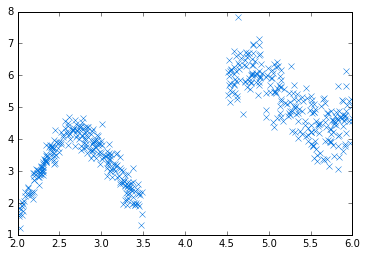

In [8]:
def test_data(num_draws = 500):
    
    def curve(x):
        return 1.5 * np.sin(3*x)  + x
    
    def noise(x):
        return np.random.normal(loc = 0.0, scale = x * 0.1)
    
    xs = []
    ys = []
    
    for _ in xrange(num_draws):
        x_1 = np.random.uniform(low = 4.5, high = 6.0)
        x_2 = np.random.uniform(low = 2.0, high = 3.5)
        x = np.random.choice([x_1, x_2])
        xs.append(x)
        ys.append(curve(x) + noise(x))
            
    features = np.concatenate([np.expand_dims(f, axis = 0) for f in xs], axis = 0)
    targets = np.concatenate([np.expand_dims(f, axis = 0) for f in ys], axis = 0)

    return features, targets

features, targets = test_data(num_draws = 500)

plt.plot(features, targets, 'x', c = colours['blue'])

Fit 100 bootstrapped networks to test data

In [9]:
gpu = monitor_gpu()
gpu.start_monitoring()

num_bootstraps = 100

# Put data in iterators 
iter_dict = bootstrap_batch_sorter(targets, features, batch_size = 50, num_bootstraps = num_bootstraps)

x = np.expand_dims(np.linspace(-1, 9, 100), 1)

start_time = time.time()

# Run the neural net to predict the mean and variance
tf.reset_default_graph()

with tf.Session() as sess:
    nn = bootstrap_NN(sess, iter_dict, num_layers = 3, num_hidden_nodes = 100,  learning_rate = 0.1, 
                target_scaling = True, feature_scaling = True, num_bootstraps = num_bootstraps, activation_fn = tf.nn.tanh)
    nn.train(num_steps = 5000, viz_every = 500)

    preds = nn.predict(x)

total_time = time.time() - start_time

print "\nTime: {:.2f} seconds".format(total_time)

gpu.stop_monitoring()

print '\nGPU average usage: {:.2f}%'.format(gpu.average_use)

Train data: 350 observations
Val data: 100 observations
Test data: 50 observations

Step: 0, Train Loss: 0.81, Val Loss: 0.81
Step: 500, Train Loss: 0.27, Val Loss: 0.27
Step: 1000, Train Loss: 0.25, Val Loss: 0.25
Step: 1500, Train Loss: 0.19, Val Loss: 0.19
Step: 2000, Train Loss: 0.14, Val Loss: 0.14
Step: 2500, Train Loss: 0.13, Val Loss: 0.13
Step: 3000, Train Loss: 0.12, Val Loss: 0.12
Step: 3500, Train Loss: 0.12, Val Loss: 0.12
Step: 4000, Train Loss: 0.12, Val Loss: 0.12
Step: 4500, Train Loss: 0.12, Val Loss: 0.12
INFO:tensorflow:checkpoint_bootstrap/NN-best is not in all_model_checkpoint_paths. Manually adding it.
Final Losses, Train: 0.11, Val: 0.11, Test: 0.17

Time: 47.89 seconds

GPU average usage: 87.87%


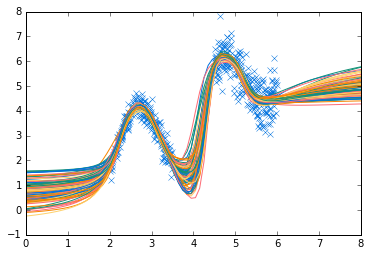

In [10]:
fig, ax = single_blog_graph()

ax.plot(features, targets, 'x', c = colours['blue'])

iterator = itertools.cycle(colours.values()[:-1])

for p in preds:
    c = iterator.next()
    ax.plot(x, p, c = c)
    
_ = ax.set_xlim([0, 8])
    
#fig.savefig('Pictures/gpu_bootstrap/bootstrap.png', dpi = 200)

An adaptation of the bootstrap NN above to allow for different learning rates for each parameter. This allows rapid experimentation to find the optimum learning rate on a GPU. At the moment just applies for simple gradient descent optimization - would need some thought for more complex optimizers

In [10]:
class learning_rate_NN(object):
    
    def __init__(self, sess, batch_iterators, num_layers = 1, num_hidden_nodes = 30, activation_fn = tf.nn.relu,
                 learning_rate = 0.00001, ind_learning_rates = [0.00001] * 10, model_name = 'NN', 
                 target_scaling = True, feature_scaling = True, checkpoint_dir = 'checkpoint_bootstrap', 
                 num_bootstraps= 10):
        
        assert len(ind_learning_rates) == num_bootstraps, 'Need to have separate learning rate for each bootstrap'
        
        self.sess = sess
        
        self.train_iter = batch_iterators['train']
        self.val_iter = batch_iterators['val']
        self.test_iter = batch_iterators['test']
        
        self.num_layers = num_layers
        self.num_hidden_nodes = num_hidden_nodes
        self.activation_fn = activation_fn
        self.learning_rate = learning_rate * num_bootstraps
        self.ind_learning_rates = ind_learning_rates
                
        self.targets_dim = self.train_iter.targets_dim
        self.features_dim = self.train_iter.features_dim
        
        self.target_scaling = target_scaling
        self.feature_scaling = feature_scaling
                
        self.num_bootstraps = num_bootstraps
        
        self.model_name = model_name
        self.checkpoint_dir = checkpoint_dir
        
        self.best_step = [0] * self.num_bootstraps
        self.best_val_losses = [float('inf')] * self.num_bootstraps
    
         # Scalers
        self.t_scaler, self.rev_t_scaler = add_scaler(self.train_iter.target_mean, self.train_iter.target_std,
                                                      scaling = self.target_scaling, name = 'targets')
        self.f_scaler, _ = add_scaler(self.train_iter.feature_mean, self.train_iter.feature_std, 
                                      scaling = self.feature_scaling, name = 'features')
        
        self.build_model()
        
        self.saver = tf.train.Saver(max_to_keep = None)
        
       
    def build_model(self):
        self.targets_pl = tf.placeholder(tf.float32, [self.num_bootstraps, None, self.targets_dim], 'targets_pl')
        self.features_pl = tf.placeholder(tf.float32, [self.num_bootstraps, None, self.features_dim], 'features_pl')
        
        # Scaling step
        self.targets = self.t_scaler(self.targets_pl)
        self.features = self.f_scaler(self.features_pl)        

        layer_list = []
        
        for layer in range(self.num_layers):
            
            if layer == 0:
                input_size = self.features_dim
                input_matrix = self.features
            else:
                input_size = self.num_hidden_nodes
                input_matrix = layer_list[layer - 1]
            
            weights = tf.Variable(tf.truncated_normal([self.num_bootstraps, input_size, self.num_hidden_nodes], stddev = 0.1), name = 'weights_layer_' + str(layer))
            bias = tf.Variable(tf.constant(0.1, shape = [self.num_bootstraps, 1, self.num_hidden_nodes]), name = 'bias_layer_' + str(layer))
                        
            layer_inner = tf.matmul(input_matrix, weights) + bias
                    
            layer_list.append(self.activation_fn(layer_inner))

        # Output layer and losses
                
        output_weights = tf.Variable(tf.truncated_normal([self.num_bootstraps, self.num_hidden_nodes, self.targets_dim], stddev = 0.1), name = 'weights_final_layer')
        output_bias = tf.Variable(tf.constant(0.1, shape = [self.num_bootstraps, 1, self.targets_dim]), name = 'bias_final_layer')
                              
        self.output = tf.matmul(layer_list[self.num_layers - 1], output_weights) + output_bias
        self.sc_output = self.rev_t_scaler(self.output)
                    
        # Create separate loss functions - these will not be used for training as faster with one loss op, but will
        # be used at eval stage
        
        self.loss_list = []
        
        for b in range(self.num_bootstraps):
            self.loss_list.append(tf.reduce_mean(tf.pow(self.targets[b,:,:] - self.output[b,:,:], 2), name = 'loss_' + str(b)))
        
        # Main loss op used for training
        self.loss = tf.reduce_mean(tf.pow(self.targets - self.output, 2), name = 'loss')
        
        # Create constant to multiply the gradients by in order to apply different learning rates
        np_lr_factors = np.expand_dims(np.expand_dims(self.ind_learning_rates/float(self.learning_rate/float(self.num_bootstraps)),1),2)
        tf_lr_factors = tf.constant(np_lr_factors, dtype = tf.float32) # shape will be [num_bootstraps * 1 * 1]
        
        # Optimizers
        self.opt = tf.train.GradientDescentOptimizer(self.learning_rate)
        grads_and_vars = self.opt.compute_gradients(self.loss)
        
        # Scale the gradients by the separate learning rate factors
        new_grads_and_vars =[(g*tf_lr_factors, v) for g, v in grads_and_vars]
        self.optimizer = self.opt.apply_gradients(new_grads_and_vars)
        
        # Trainable vars
        self.trainable_vars = tf.trainable_variables()

    def train(self, viz_every = 500, num_steps = 5000):
        
        self.start_time = time.time()
        
        best_val_loss = float('inf')
        
        self.sess.run(tf.global_variables_initializer())
                
        for step in xrange(num_steps):
            
            t_batch, f_batch = self.train_iter.next_batch()
            
            # Initially just train the mean prediction network 
            _ = self.sess.run(self.optimizer, feed_dict = {self.features_pl: f_batch, 
                                    self.targets_pl: t_batch})

            if step % viz_every == 0:
                
                _, TRAIN_LOSSES = self.run_data_set(self.train_iter)
                _, VAL_LOSSES = self.run_data_set(self.train_iter)
                                
                print "Step: {0}, Train Loss: {1:.2f}, Val Loss: {2:.2f}".format(step,
                                        np.average(TRAIN_LOSSES), np.average(VAL_LOSSES))    
                
                save_update = False
                
                # Update the best val losses
                for b in range(self.num_bootstraps):
                    if VAL_LOSSES[b] < self.best_val_losses[b]:
                        self.best_val_losses[b] = VAL_LOSSES[b]
                        self.best_step[b] = step
                        save_update = True
                
                # Save if any of the separate bootstrapped networks have improved on their best val loss
                if save_update:                    
                    T_VARS = self.sess.run(self.trainable_vars)
                    self.update_t_vars(T_VARS, step = step)
                    
        self.restore_best_vars()
                
        self.TRAIN_PREDS, self.TRAIN_LOSSES = self.run_data_set(self.train_iter)
        self.VAL_PREDS, self.VAL_LOSSES = self.run_data_set(self.train_iter)
        self.TEST_PREDS, self.TEST_LOSSES = self.run_data_set(self.test_iter)
                
        print "Final Losses, Train: {1:.2f}, Val: {2:.2f}, Test: {3:.2f}".format(step,
                                            np.average(self.TRAIN_LOSSES), np.average(self.VAL_LOSSES), np.average(self.TEST_LOSSES)) 
        
                    
    
    def run_data_set(self, iterator):
        
        # Store starting value of iterator to return to
        counter_start = iterator.counter
        # Make sure we start from the first batch
        iterator.counter = 0
        
        preds_dict = {}
        loss_dict = {}
        
        for b in range(self.num_bootstraps):
            preds_dict[b] = []
            loss_dict[b] = []
        
        for step in xrange(iterator.num_batches):
            
            t_batch, f_batch = iterator.next_batch()
            
            OUTPUT = self.sess.run([self.sc_output] + self.loss_list, feed_dict = {self.features_pl: f_batch, 
                                                    self.targets_pl: t_batch})
                 
            LOSSES = OUTPUT[1:]
            PREDS = OUTPUT[0]
            
            for b in range(self.num_bootstraps):
                preds_dict[b].append(PREDS[b, :, :])
                loss_dict[b].append(LOSSES[b])
                
        all_preds_list = []
        average_loss_list = []
        
        for b in range(self.num_bootstraps):
            all_preds_list.append(np.concatenate(preds_dict[b], axis = 0))
            average_loss_list.append(np.average(loss_dict[b]))
        # Return iterator counter to starting value
        iterator.counter = counter_start
        
        return all_preds_list, average_loss_list          
        

    
    def update_t_vars(self, current_vars, step):
        
        if not hasattr(self, 'best_vars'):            
            self.best_vars = [np.zeros_like(v) for v in current_vars]
        
        # If loss was lowest for this bootstrap with these variables, update our new best variables
        for b in range(self.num_bootstraps):
            if self.best_step[b] == step:
                # Assign the correct parts of these variables to our new var list
                for num, v in enumerate(self.best_vars):
                    v[b] = current_vars[num][b]      
    
    def predict(self, features):
        
        self.restore_best_vars(save = False)
        
        features_batch = np.tile(np.expand_dims(features, axis = 0), [self.num_bootstraps, 1, 1])
        
        PREDS = self.sess.run(self.sc_output, feed_dict = {self.features_pl: features_batch})
        
        preds_list = []
        
        for b in range(self.num_bootstraps):
            preds_list.append(PREDS[b,:,:])
        
        return preds_list
   
    def save(self, key = None):
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
        if key:
            self.saver.save(self.sess, self.checkpoint_dir + '/' + self.model_name + '-' + str(key))        

    def restore_best_vars(self, save = True):
        # Assign the new vars which we have created to the variables in the original graph
        all_assign_ops = [v.assign(self.best_vars[num]) for num, v in enumerate(self.trainable_vars)]
        self.sess.run(all_assign_ops)
        
        if save:
            # Save the new combined best variables and delete the null old checkpoints
            self.save(key = 'best')
            
    def best_learning_rate(self):
        ix = np.argmin(self.VAL_LOSSES)
        best_learning_rate = self.ind_learning_rates[ix]        
        print "\nBest learning rate: {:.3f}, train loss: {:.2f}, val loss: {:.2f}, test loss: {:.2f}".format(best_learning_rate,
                                                                                self.TRAIN_LOSSES[ix], self.VAL_LOSSES[ix], self.TEST_LOSSES[ix])

Experiment with 100 different learning rates on the housing data

In [11]:
gpu = monitor_gpu()
gpu.start_monitoring()

num_bootstraps = 100

# Put data in iterators 
iter_dict = bootstrap_batch_sorter(housing_targets, housing_features, batch_size = 50, num_bootstraps = num_bootstraps)

start_time = time.time()

ind_learning_rates = np.linspace(0.000001, 0.5, num_bootstraps)

# Run the neural net to predict the mean and variance
tf.reset_default_graph()

with tf.Session() as sess:
    nn = learning_rate_NN(sess, iter_dict, num_layers = 2, num_hidden_nodes = 20, ind_learning_rates = ind_learning_rates,
                target_scaling = True, feature_scaling = True, num_bootstraps = num_bootstraps, activation_fn = tf.nn.tanh)
    nn.train(num_steps = 3000, viz_every = 500)
    nn.best_learning_rate()

total_time = time.time() - start_time

print "\nTime: {:.2f} seconds".format(total_time)

gpu.stop_monitoring()

print '\nGPU average usage: {:.2f}%'.format(gpu.average_use)

Train data: 350 observations
Val data: 100 observations
Test data: 56 observations

Step: 0, Train Loss: 0.89, Val Loss: 0.89
Step: 500, Train Loss: 0.14, Val Loss: 0.14
Step: 1000, Train Loss: 0.10, Val Loss: 0.10
Step: 1500, Train Loss: 0.08, Val Loss: 0.08
Step: 2000, Train Loss: 0.07, Val Loss: 0.07
Step: 2500, Train Loss: 0.06, Val Loss: 0.06
INFO:tensorflow:checkpoint_bootstrap/NN-best is not in all_model_checkpoint_paths. Manually adding it.
Final Losses, Train: 0.06, Val: 0.06, Test: 0.16

Best learning rate: 0.419, train loss: 0.03, val loss: 0.03, test loss: 0.16

Time: 22.13 seconds

GPU average usage: 80.20%


Plot the val losses for each learning rate

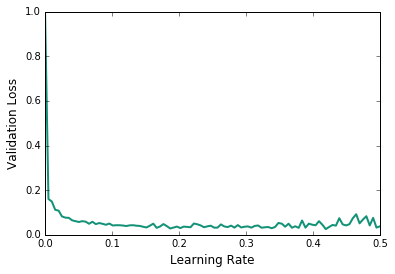

In [12]:
fig, ax = single_blog_graph()

ax.plot(nn.ind_learning_rates, nn.VAL_LOSSES, c = colours['green'], linewidth = 2.0)
ax.set_xlabel('Learning Rate')
_ = ax.set_ylabel('Validation Loss')

An attempt at providing a version which works with multiple different layer sizes - works mathematically, but doesn't utilize the GPU effectively in current form, so much slower

In [13]:
class variable_size_NN(object):
    
    def __init__(self, sess, batch_iterators, num_hidden_nodes, activation_fn = tf.nn.relu,
                 learning_rate = 0.00001, model_name = 'NN', target_scaling = True, feature_scaling = True,
                 checkpoint_dir = 'checkpoint_bootstrap', num_bootstraps= 10):
        
        self.sess = sess
        
        self.train_iter = batch_iterators['train']
        self.val_iter = batch_iterators['val']
        self.test_iter = batch_iterators['test']
        
        self.num_layers = num_hidden_nodes.shape[1]
        self.num_hidden_nodes = num_hidden_nodes
        self.activation_fn = activation_fn
        self.learning_rate = learning_rate * num_bootstraps
                
        self.targets_dim = self.train_iter.targets_dim
        self.features_dim = self.train_iter.features_dim
        
        self.target_scaling = target_scaling
        self.feature_scaling = feature_scaling
                
        self.num_bootstraps = num_bootstraps
        
        self.model_name = model_name
        self.checkpoint_dir = checkpoint_dir
        
        self.best_step = [0] * self.num_bootstraps
        self.best_val_losses = [float('inf')] * self.num_bootstraps
    
        
         # Scalers
        self.t_scaler, self.rev_t_scaler = add_scaler(self.train_iter.target_mean, self.train_iter.target_std,
                                                      scaling = self.target_scaling, name = 'targets')
        self.f_scaler, _ = add_scaler(self.train_iter.feature_mean, self.train_iter.feature_std, 
                                      scaling = self.feature_scaling, name = 'features')
        
        self.build_model()
        
        self.saver = tf.train.Saver(max_to_keep = None)
        
       
    def build_model(self):
        self.targets_pl = tf.placeholder(tf.float32, [self.num_bootstraps, None, self.targets_dim], 'targets_pl')
        self.features_pl = tf.placeholder(tf.float32, [self.num_bootstraps, None, self.features_dim], 'features_pl')
        
        # Scaling step
        self.targets = self.t_scaler(self.targets_pl)
        self.features = self.f_scaler(self.features_pl)        

        layer_list = []
        self.var_list = []
        
        for layer in range(self.num_layers):
            
            if layer == 0:
                input_size = np.tile(self.features_dim, [self.num_bootstraps])
                input_matrix = self.features
                max_previous = self.features_dim
            else:
                input_size = self.num_hidden_nodes[:,layer-1]
                input_matrix = layer_list[layer - 1]
                max_previous = np.max(input_size)
            
            weights_list = []
            bias_list = []
            max_current = np.max(self.num_hidden_nodes[:,layer])
            
            for b in range(self.num_bootstraps):
                trainable_weights = tf.Variable(tf.truncated_normal([1, input_size[b], self.num_hidden_nodes[b,layer]], stddev = 0.1), 
                                                name = 'weights_layer_' + str(layer) + '_' + str(b))
                padding_current = tf.Variable(tf.constant(0.0, shape = [1, input_size[b], max_current - self.num_hidden_nodes[b,layer]]), trainable = False)
                padding_previous = tf.Variable(tf.constant(0.0, shape = [1, max_previous - input_size[b], max_current]), trainable = False)
                
                joined = tf.concat([trainable_weights, padding_current], axis = 2)
                joined_2 = tf.concat([joined, padding_previous], axis = 1)
                weights_list.append(joined_2)
                
                bias_trainable = tf.Variable(tf.constant(0.1, shape = [1, 1, self.num_hidden_nodes[b,layer]]), name = 'bias_layer_' + str(layer) +'_' + str(b))
                bias_padding = tf.Variable(tf.constant(0.0, shape = [1,1,max_current - self.num_hidden_nodes[b,layer]]), trainable = False)
                bias_list.append(tf.concat([bias_trainable, bias_padding], axis = 2))
                
            weights = tf.concat(weights_list, axis = 0)
            bias = tf.concat(bias_list, axis = 0)
            
            self.var_list.append(weights)
            self.var_list.append(bias)
            
            layer_inner = tf.matmul(input_matrix, weights) + bias
                    
            layer_list.append(self.activation_fn(layer_inner))

        # Output layer and losses
        out_weights = []
        out_bias = []
        
        for b in range(self.num_bootstraps):
            input_size = self.num_hidden_nodes[:,-1]
            max_previous = np.max(input_size)
            trainable_out_weights = tf.Variable(tf.truncated_normal([1, input_size[b], self.targets_dim], stddev = 0.1), 
                                         name = 'weights_final_layer_' + str(b))
            output_padding = tf.Variable(tf.constant(0.0, shape = [1, max_previous - input_size[b], self.targets_dim]), trainable = False)
            out_weights.append(tf.concat([trainable_out_weights, output_padding], axis = 1))
            
        output_bias = tf.Variable(tf.constant(0.1, shape = [self.num_bootstraps,1, self.targets_dim]), name = 'bias_final_layer')          
        output_weights = tf.concat(out_weights, axis = 0)
        
        self.var_list.append(output_weights)
        self.var_list.append(output_bias)
        
        self.output = tf.matmul(layer_list[self.num_layers - 1], output_weights) + output_bias
        self.sc_output = self.rev_t_scaler(self.output)
                    
        # Create separate loss functions - these will not be used for training as faster with one loss op, but will
        # be used at eval stage
        
        self.loss_list = []
        
        for b in range(self.num_bootstraps):
            self.loss_list.append(tf.reduce_mean(tf.pow(self.targets[b,:,:] - self.output[b,:,:], 2), name = 'loss_' + str(b)))
        
        # Main loss op used for training
        self.loss = tf.reduce_mean(tf.pow(self.targets - self.output, 2), name = 'loss')
                       
        # Optimizers
        self.optimizer = tf.train.GradientDescentOptimizer(self.learning_rate).minimize(self.loss)
        
    def train(self, viz_every = 500, num_steps = 5000):
        
        self.start_time = time.time()
        
        best_val_loss = float('inf')
        
        self.sess.run(tf.global_variables_initializer())
                
        for step in xrange(num_steps):
            
            t_batch, f_batch = self.train_iter.next_batch()
            
            # Initially just train the mean prediction network 
            _ = self.sess.run(self.optimizer, feed_dict = {self.features_pl: f_batch, 
                                    self.targets_pl: t_batch})

            if step % viz_every == 0:
                
                _, TRAIN_LOSSES = self.run_data_set(self.train_iter)
                _, VAL_LOSSES = self.run_data_set(self.train_iter)
                                
                print "Step: {0}, Train Loss: {1:.2f}, Val Loss: {2:.2f}".format(step,
                                        np.average(TRAIN_LOSSES), np.average(VAL_LOSSES))    
                
                save_update = False
                
                # Update the best val losses
                for b in range(self.num_bootstraps):
                    if VAL_LOSSES[b] < self.best_val_losses[b]:
                        self.best_val_losses[b] = VAL_LOSSES[b]
                        self.best_step[b] = step
                        save_update = True
                
                # Save if any of the separate bootstrapped networks have improved on their best val loss
                if save_update:                    
                    T_VARS = self.sess.run(self.var_list)
                    self.update_t_vars(T_VARS, step = step)
                    
        #self.restore_best_vars()
                
        self.TRAIN_PREDS, self.TRAIN_LOSSES = self.run_data_set(self.train_iter)
        self.VAL_PREDS, self.VAL_LOSSES = self.run_data_set(self.train_iter)
        self.TEST_PREDS, self.TEST_LOSSES = self.run_data_set(self.test_iter)
                
        print "Final Losses, Train: {1:.2f}, Val: {2:.2f}, Test: {3:.2f}".format(step,
                                            np.average(self.TRAIN_LOSSES), np.average(self.VAL_LOSSES), np.average(self.TEST_LOSSES)) 
        
                    
    
    def run_data_set(self, iterator):
        
        # Store starting value of iterator to return to
        counter_start = iterator.counter
        # Make sure we start from the first batch
        iterator.counter = 0
        
        preds_dict = {}
        loss_dict = {}
        
        for b in range(self.num_bootstraps):
            preds_dict[b] = []
            loss_dict[b] = []
        
        for step in xrange(iterator.num_batches):
            
            t_batch, f_batch = iterator.next_batch()
            
            OUTPUT = self.sess.run([self.sc_output] + self.loss_list, feed_dict = {self.features_pl: f_batch, 
                                                    self.targets_pl: t_batch})
                 
            LOSSES = OUTPUT[1:]
            PREDS = OUTPUT[0]
            
            for b in range(self.num_bootstraps):
                preds_dict[b].append(PREDS[b, :, :])
                loss_dict[b].append(LOSSES[b])
                
        all_preds_list = []
        average_loss_list = []
        
        for b in range(self.num_bootstraps):
            all_preds_list.append(np.concatenate(preds_dict[b], axis = 0))
            average_loss_list.append(np.average(loss_dict[b]))
        # Return iterator counter to starting value
        iterator.counter = counter_start
        
        return all_preds_list, average_loss_list          
        

    
    def update_t_vars(self, current_vars, step):
        
        if not hasattr(self, 'best_vars'):            
            self.best_vars = [np.zeros_like(v) for v in current_vars]
        
        # If loss was lowest for this bootstrap with these variables, update our new best variables
        for b in range(self.num_bootstraps):
            if self.best_step[b] == step:
                # Assign the correct parts of these variables to our new var list
                for num, v in enumerate(self.best_vars):
                    v[b] = current_vars[num][b]      
    
    def predict(self, features):
        
        #self.restore_best_vars(save = False)
        
        features_batch = np.tile(np.expand_dims(features, axis = 0), [self.num_bootstraps, 1, 1])
        
        PREDS = self.sess.run(self.sc_output, feed_dict = {self.features_pl: features_batch})
        
        preds_list = []
        
        for b in range(self.num_bootstraps):
            preds_list.append(PREDS[b,:,:])
        
        return preds_list
   
    def save(self, key = None):
        if not os.path.exists(self.checkpoint_dir):
            os.makedirs(self.checkpoint_dir)
        if key:
            self.saver.save(self.sess, self.checkpoint_dir + '/' + self.model_name + '-' + str(key))        

    def restore_best_vars(self, save = True):
        # Assign the new vars which we have created to the variables in the original graph
        all_assign_ops = [v.assign(self.best_vars[num]) for num, v in enumerate(self.var_list)]
        self.sess.run(all_assign_ops)
        
        if save:
            # Save the new combined best variables and delete the null old checkpoints
            self.save(key = 'best')

Run the variable sizes network - at the moment this doesn't utilize the GPU effectively

In [14]:
gpu = monitor_gpu()
gpu.start_monitoring()

layer_sizes = [[10,20,30,40,50],[10,20,30,40],[10,20,30,40]]
hidden_nodes = np.array(list(itertools.product(*layer_sizes)))

# Put data in iterators 
iter_dict = bootstrap_batch_sorter(targets, features, batch_size = 50, num_bootstraps = hidden_nodes.shape[0])

x = np.expand_dims(np.linspace(-1, 9, 100), 1)

start_time = time.time()

# Run the neural net to predict the mean and variance
tf.reset_default_graph()

with tf.Session() as sess:
    nn = variable_size_NN(sess, iter_dict, num_hidden_nodes = hidden_nodes, learning_rate = 0.1, 
                target_scaling = True, feature_scaling = True, num_bootstraps = hidden_nodes.shape[0], activation_fn = tf.nn.tanh)
    nn.train(num_steps = 2000, viz_every = 500)

    preds = nn.predict(x)

total_time = time.time() - start_time

print "\nTime: {:.2f} seconds".format(total_time)

gpu.stop_monitoring()

print '\nGPU average usage: {:.2f}%'.format(gpu.average_use)

Train data: 350 observations
Val data: 100 observations
Test data: 50 observations

Step: 0, Train Loss: 1.00, Val Loss: 1.00
Step: 500, Train Loss: 0.27, Val Loss: 0.27
Step: 1000, Train Loss: 0.25, Val Loss: 0.25
Step: 1500, Train Loss: 0.24, Val Loss: 0.24
Final Losses, Train: 0.22, Val: 0.22, Test: 0.22

Time: 88.28 seconds

GPU average usage: 57.13%
